<h4>Importing the necessary libraries<h4>

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

<h4>Defining the configuration of the model<h4>

In [2]:
# Batch size for training.
batch_size = 64
# Number of epochs to train for.
epochs = 30
# Latent dimensionality of the encoding space.
latent_dim = 256
# Number of samples to train on.
num_samples = 10000
# Path to the data txt file on disk.
data_path = "english_french.txt"

<h4>Preparing the encoder input, decoder input and decoder target data<h4>

In [3]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    #for target texts
    #"start sequence" character = "\t"
    #"end sequence" character = "\n"
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
#max number of input characters
num_encoder_tokens = len(input_characters)
#max number of output characters
num_decoder_tokens = len(target_characters)
#max input length
max_encoder_seq_length = max([len(txt) for txt in input_texts])
#max output length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [5]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text): 
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data is ahead of decoder_input_data by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0
print('Encoder input data:\n', encoder_input_data)
print('\n\nDecoder input data:\n', decoder_input_data)
print('\n\nDecoder target data:\n', decoder_target_data)

Encoder input data:
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0

<h4>Building the model<h4>

In [6]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [7]:
#Summary of the encoder decoder model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]            

<h4>Training the model<h4>

In [8]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_lstm=model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


Epoch 1/30
125/125 [==============================] - 28s 224ms/step - loss: 1.1489 - accuracy: 0.7321 - val_loss: 1.0769 - val_accuracy: 0.7265
Epoch 2/30
125/125 [==============================] - 28s 221ms/step - loss: 0.8334 - accuracy: 0.7757 - val_loss: 0.9858 - val_accuracy: 0.7473
Epoch 3/30
125/125 [==============================] - 27s 219ms/step - loss: 0.6620 - accuracy: 0.8141 - val_loss: 0.7047 - val_accuracy: 0.7928
Epoch 4/30
125/125 [==============================] - 28s 220ms/step - loss: 0.5848 - accuracy: 0.8307 - val_loss: 0.6421 - val_accuracy: 0.8109
Epoch 5/30
125/125 [==============================] - 28s 222ms/step - loss: 0.5357 - accuracy: 0.8430 - val_loss: 0.6008 - val_accuracy: 0.8239
Epoch 6/30
125/125 [==============================] - 28s 221ms/step - loss: 0.4989 - accuracy: 0.8533 - val_loss: 0.5690 - val_accuracy: 0.8349
Epoch 7/30
125/125 [==============================] - 28s 222ms/step - loss: 0.4696 - accuracy: 0.8613 - val_loss: 0.5439 - val_ac

<h4>Plotting the loss and accuracy of training and test datasets<h4>

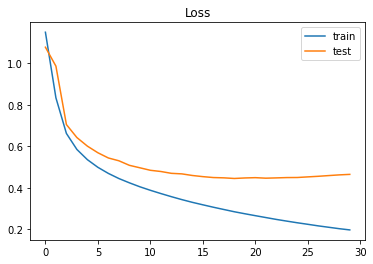

In [9]:
plt.plot(history_lstm.history['loss'], label = 'train')
plt.plot(history_lstm.history['val_loss'], label = 'test')
plt.title('Loss')
plt.legend()
plt.show()

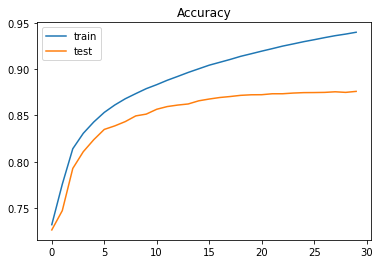

In [10]:
plt.plot(history_lstm.history['accuracy'], label = 'train')
plt.plot(history_lstm.history['val_accuracy'], label = 'test')
plt.title('Accuracy')
plt.legend()
plt.show()

<h4>Inference steps:<h4>
<br>1.Encode the input sentence and retrieve the initial decoder state.<br>
<br>2.Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next characte.<br>
<br>3.Append the target character predicted and repeat till the end sequence character or character limit is reached.<br>

In [11]:
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")
#model.summary()

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index for the decoded sequences
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

<h4>Defining the decode sequence module<h4>

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length or find stop sequence.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

<h4>Sample translations<h4>

In [17]:
for seq_index in range(20,40):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("***********************")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
    print("***********************\n")

***********************
Input sentence: Run.
Decoded sentence: Cours !

***********************

***********************
Input sentence: Who?
Decoded sentence: Qui détart ?

***********************

***********************
Input sentence: Wow!
Decoded sentence: Faisons-le !

***********************

***********************
Input sentence: Fire!
Decoded sentence: Arrête !

***********************

***********************
Input sentence: Help!
Decoded sentence: Allez !

***********************

***********************
Input sentence: Jump!
Decoded sentence: Attrapez !

***********************

***********************
Input sentence: Jump.
Decoded sentence: Attrapez !

***********************

***********************
Input sentence: Stop!
Decoded sentence: Arrêtez !

***********************

***********************
Input sentence: Stop!
Decoded sentence: Arrêtez !

***********************

***********************
Input sentence: Stop!
Decoded sentence: Arrêtez !

***********************

